# 0.5_ss_chap5

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%reload_ext autoreload

In [4]:

from src import utils
import itertools
import logging
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [5]:

log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt)
# logging.basicConfig(level=logging.DEBUG, format=log_fmt)
logger = logging.getLogger()

## Backward propagation

In [14]:
class MulLayer:
        def __init__(self):
                ''' Multiplication interface for backward propagation
                Multiplication returns f(x,y) =x * y
                The chain rule stands: df/dx = y, df/dy = x 
                Backward propagation is: dx = dout * df/dx = dout * y
                Backward propagation is: dy = dout * df/dy = dout * x
                
                Properties
                x: num
                        Forward x
                y: num
                        Forward y
                '''
                self.x = None
                self.y = None
        
        def forward(self, x, y):
                ''' Forward method of multiplication
                Initalized x, y on forward
                '''
                self.x = x
                self.y = y
                out = x * y
                
                return out
        
        def backward(self, dout):
                ''' Backward method of multiplication
                Chain rule follows that df/dx=y, df/dx=x
                '''
                dx = dout * self.y
                dy = dout * self.x
                
                return dx, dy


In [15]:
apple = 100
apple_num = 2
tax = 1.1

In [16]:
# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

In [17]:
# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

In [18]:
print(price)

220.00000000000003


In [19]:
# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)

In [20]:
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

In [21]:
print(dapple)

2.2


In [22]:
print(dapple_num)

110.00000000000001


## Add

In [23]:
class AddLayer:
        ''' add interface for backward propagation
        add returns f(x,y) =x + y
        The chain rule stands: df/dx = 1, df/dy = 1 
        Backward propagation is: dx = dout * df/dx = dout * 1
        Backward propagation is: dy = dout * df/dy = dout * 1

        Properties
        x: num
                Forward x
        y: num
                Forward y
        '''
        def __init__(self):
                pass
        
        def forward(self, x, y):
                out = x + y
                return out
        
        def backward(self, dout):
                dx = dout * 1
                dy = dout * 1
                return dx, dy

In [24]:
orange = 150
orange_num = 3

In [26]:
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()

In [27]:
orange_price = mul_orange_layer.forward(orange, orange_num)

In [28]:
all_price = add_apple_orange_layer.forward(apple_price, orange_price)

In [29]:
price = mul_tax_layer.forward(all_price, tax)

### backward

In [31]:
dprice = 1

In [32]:
dall_price, dtax = mul_tax_layer.backward(dprice)

In [34]:
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)

In [35]:
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

In [36]:
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

In [37]:
print(price)

715.0000000000001


In [38]:
dapple_num

110.00000000000001

In [40]:
dorange_num

165.0

## Activation

### Relu

In [43]:
class Relu:
        ''' Relu activation
        f(x) = x (x > 0), 0 (x <=0)
        df/dx = 1(x>0), 0(x<=0)
        '''
        def __init__(self):
                self.mask = None
        
        def forward(self, x):
                ''' output relu
                
                Parameters
                ----------
                x: numpy array
                
                Returns
                -------
                out: numpy array
                        masked as 0 where x<=0
                '''
                self.mask = (x <= 0)
                out = x.copy()
                out[self.mask] = 0
                
                return out
        
        def backward(self, dout):
                dout[self.mask] = 0
                dx = dout
                
                return dx

### Sigmoid

In [44]:
class Sigmoid:
        ''' Sigmoid interface
        y = f(x) = 1/(1+exp(-x))
        dy/dx = exp(-x)/(1+exp(-x))^2 = y(1-y)
        '''
        def __init__(self):
                self.out = None
        
        def forward(self, x):
                out = 1/(1+np.exp(-x))
                self.out = out
                
                return out
        
        def backward(self, dout):
                dx = dout * (1.0 - self.out) * self.out
                
                return dx

In [45]:
class Affine:
        ''' Interface for affine transformation (dot product)
        f(x, W, b) = x %*% W + b
        df/dx = W.T
        df/dW = x.T
        df/db = 1
        
        '''
        def __init__(self, W, b):
                self.W = W
                self.x = None
                self.dW = None
                self.db = None
        
        def forward(self, x):
                self.x = x
                out = np.dot(x, self.W) + self.b
                
                return out
        
        def backward(self, dout):
                dx = np.dot(dout, self.W.T)
                self.dW = np.dot(self.x.T, dout)
                self.db = np.sum(dout, axis=0)
                
                return dx

### Error

In [46]:
from src.common.functions import softmax, cross_entropy_error

In [47]:
class SoftmaxWithLoss:
        def __init__(self):
                self.loss = None
                self.y = None
                self.t = None
        
        def forward(self, x, t):
                self.t = t
                self.y = softmax(x)
                self.loss = cross_entropy_error(self.y, self.t)
                
                return self.loss
        
        def backward(self, dout=1):
                batch_size = self.t.shape[0]
                dx = (self.y - self.t)/batch_size
                
                return dx

In [51]:
from src.common.layers import *
from src.common.gradient import numerical_gradient
from collections import OrderedDict

In [64]:
class TwoLayerNet:
        ''' Two layered net
        '''
        def __init__(self, input_size, hidden_size, output_size,
                    weight_init_std = 0.01):
                # Initialize
                self.params={}
                self.params['W1'] = weight_init_std * \
                        np.random.randn(input_size, hidden_size)
                self.params['b1'] = np.zeros(hidden_size)
                self.params['W2'] = weight_init_std * \
                        np.random.randn(hidden_size, output_size)
                self.params['b2'] = np.zeros(output_size)
                
                # Layers
                self.layers = OrderedDict()
                self.layers['Affine1'] = Affine(self.params['W1'],
                                               self.params['b1'])
                self.layers['Relu1'] = Relu()
                self.layers['Affine2'] = Affine(self.params['W2'],
                                               self.params['b2'])
                
                self.lastLayer = SoftmaxWithLoss()

        def predict(self, x):
                for layer in self.layers.values():
                        x = layer.forward(x)
                
                return x
        
        # x: in, t: out
        def loss(self, x, t):
                y = self.predict(x)
                return self.lastLayer.forward(y, t)
        
        def accuracy(self, x, t):
                y = self.predict(x)
                y = np.argmax(y, axis=1)
                if t.ndim != 1: 
                        t = np.argmax(t, axis=1)
                accuracy = np.sum(y==t)/float(x.shape[0])
                
                return accuracy
        
        def numerical_gradient(self, x, t):
                loss_W = lambda W: self.loss(x, t)
                
                grads = {}
                grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
                grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
                grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
                grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
                
                return grads
        
        def gradient(self, x, t):
                # forward
                self.loss(x, t)
                
                # backward
                dout = 1
                dout = self.lastLayer.backward(dout)
                
                layers = list(self.layers.values())
                layers.reverse()
                for layer in layers:
                        dout = layer.backward(dout)
                        
                # input
                grads = {}
                grads['W1'] = self.layers['Affine1'].dW
                grads['b1'] = self.layers['Affine1'].db
                grads['W2'] = self.layers['Affine2'].dW
                grads['b2'] = self.layers['Affine2'].db
                
                return grads
                

## Gradient check

In [55]:
from src.dataset.mnist import load_mnist

In [56]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, 
                                                  one_hot_label=True)

In [66]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [67]:
x_batch = x_train[:3]
t_batch = t_train[:3]

In [68]:
x_batch

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [69]:
grad_numerical = network.numerical_gradient(x_batch, t_batch)

In [70]:
grad_backprop = network.gradient(x_batch, t_batch)

In [71]:
for key in grad_numerical.keys():
        diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
        logger.info(f"{key}: {diff}")

2018-11-04 18:53:19,609 - src.common.layers - INFO - W1: 4.246875568409945e-10
2018-11-04 18:53:19,610 - src.common.layers - INFO - b1: 2.4277005349551273e-09
2018-11-04 18:53:19,613 - src.common.layers - INFO - W2: 5.425777944473201e-09
2018-11-04 18:53:19,617 - src.common.layers - INFO - b2: 1.3944884606070795e-07


# 学習

In [72]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, 
                                                  one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [73]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)

In [80]:
%%time
for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        # gradients by back propagation
        grad = network.gradient(x_batch, t_batch)
        
        # update
        for key in ('W1', 'b1', 'W2', 'b2'):
                network.params[key] -= learning_rate * grad[key]
        
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        
        if i % iter_per_epoch == 0:
                train_acc = network.accuracy(x_train, t_train)
                test_acc = network.accuracy(x_test, t_test)
                train_acc_list.append(train_acc)
                test_acc_list.append(test_acc)
                logger.info(f"Train: {train_acc}, test: {test_acc}")

2018-11-04 22:11:17,714 - src.common.layers - INFO - Train: 0.98975, test: 0.9729
2018-11-04 22:11:19,511 - src.common.layers - INFO - Train: 0.9908, test: 0.9742
2018-11-04 22:11:20,974 - src.common.layers - INFO - Train: 0.9918333333333333, test: 0.9739
2018-11-04 22:11:22,414 - src.common.layers - INFO - Train: 0.9916666666666667, test: 0.9727
2018-11-04 22:11:23,917 - src.common.layers - INFO - Train: 0.99215, test: 0.9744
2018-11-04 22:11:25,349 - src.common.layers - INFO - Train: 0.9925, test: 0.9734
2018-11-04 22:11:26,777 - src.common.layers - INFO - Train: 0.9930666666666667, test: 0.9747
2018-11-04 22:11:28,229 - src.common.layers - INFO - Train: 0.9934, test: 0.9742
2018-11-04 22:11:29,748 - src.common.layers - INFO - Train: 0.9935833333333334, test: 0.9743
2018-11-04 22:11:31,192 - src.common.layers - INFO - Train: 0.99235, test: 0.9741
2018-11-04 22:11:32,627 - src.common.layers - INFO - Train: 0.99445, test: 0.9742
2018-11-04 22:11:34,105 - src.common.layers - INFO - Trai

CPU times: user 41.8 s, sys: 4.49 s, total: 46.3 s
Wall time: 25.1 s


In [81]:
iter_per_epoch

600.0

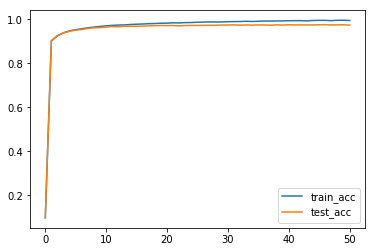

In [82]:
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label = 'train_acc')
plt.plot(x, test_acc_list, label = 'test_acc')
plt.legend()